# WLASL100 Dynamic Word Classification with Temporal Modeling
### By: Munish Shah - DAEN 429 Course Project (Phase 2 - Bonus)

## 1. Setup & Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import os
import json
import cv2
from PIL import Image
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings('ignore')

SEED = 429 #Required Seed 
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## 2. Mount Google Drive & Extract Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/My Drive/ASL_Project'
CHECKPOINT_DIR = f'{PROJECT_DIR}/checkpoints'
PHASE2_CHECKPOINT_DIR = f'{CHECKPOINT_DIR}/phase2'
os.makedirs(PHASE2_CHECKPOINT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
if not os.path.exists('wlasl100'): #I put my data in google drive and extract in colab
    !cp "{PROJECT_DIR}/wlasl100.zip" .
    !unzip -q wlasl100.zip
    !rm wlasl100.zip
    print('WLASL100 data extracted')
else:
    print('WLASL100 data already extracted.')

WLASL100 data extracted


## 3. Configuration

In [ ]:
WLASL_DIR = 'WLASL_100'
TRAIN_DIR = f'{WLASL_DIR}/train'
VAL_DIR = f'{WLASL_DIR}/val'
TEST_DIR = f'{WLASL_DIR}/test'

IMG_SIZE = 224 #Resnet input size
NUM_CLASSES = 100
FEATURE_DIM = 512
HIDDEN_DIM = 256
NUM_FRAMES = 16

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 30

print(f'Train directory exists: {os.path.exists(TRAIN_DIR)}')
print(f'Val directory exists: {os.path.exists(VAL_DIR)}')
print(f'Test directory exists: {os.path.exists(TEST_DIR)}')

Train directory exists: True
Val directory exists: True
Test directory exists: True


## 4. Load Best Phase 1 Model as Feature Extractor

In [5]:
def create_feature_extractor():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(512, 29)

    checkpoint_path = f'{CHECKPOINT_DIR}/T-C_best.pt'
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    print(f'Loaded Phase 1 checkpoint: {checkpoint_path}')

    model.fc = nn.Identity()
    return model.to(DEVICE)

feature_extractor = create_feature_extractor()
print(f'Feature extractor ready. Output dim: {FEATURE_DIM}')

Loaded Phase 1 checkpoint: /content/drive/My Drive/ASL_Project/checkpoints/T-C_best.pt
Feature extractor ready. Output dim: 512


## 5. Video Dataset

In [ ]:
class VideoDataset(Dataset): #Dataset class for loading videos
    def __init__(self, root_dir, transform=None, num_frames=16):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for video_name in os.listdir(class_dir): #Loop through all videos in the class directory
                video_path = os.path.join(class_dir, video_name)
                if os.path.isdir(video_path) or video_path.endswith(('.mp4', '.avi', '.mov')):
                    self.samples.append((video_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def _load_frames(self, video_path): #Load frames from video
        frames = []
        if os.path.isdir(video_path):
            frame_files = sorted([f for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
            indices = np.linspace(0, len(frame_files) - 1, self.num_frames, dtype=int)
            for idx in indices:
                frame_path = os.path.join(video_path, frame_files[idx])
                img = Image.open(frame_path).convert('RGB')
                frames.append(img)
        else:
            cap = cv2.VideoCapture(video_path) #Load video frames
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx) #Set frame position
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(Image.fromarray(frame)) #Convert frame to PIL image
            cap.release()

        while len(frames) < self.num_frames:
            frames.append(frames[-1] if frames else Image.new('RGB', (IMG_SIZE, IMG_SIZE)))

        return frames[:self.num_frames]

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_frames(video_path)

        if self.transform:
            frames = [self.transform(f) for f in frames]

        frames = torch.stack(frames)
        return frames, label

video_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

train_dataset = VideoDataset(TRAIN_DIR, transform=video_transform, num_frames=NUM_FRAMES)
val_dataset = VideoDataset(VAL_DIR, transform=video_transform, num_frames=NUM_FRAMES)
test_dataset = VideoDataset(TEST_DIR, transform=video_transform, num_frames=NUM_FRAMES)

print(f'Train videos: {len(train_dataset)}')
print(f'Val videos: {len(val_dataset)}')
print(f'Test videos: {len(test_dataset)}')
print(f'Classes: {len(train_dataset.classes)}')

Train videos: 1001
Val videos: 242
Test videos: 200
Classes: 100


In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=9, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=9, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=9, pin_memory=True)

## 6. Temporal Models

In [ ]:
class VideoClassifier(nn.Module):
    def __init__(self, feature_extractor, hidden_dim=256, num_classes=100):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.lstm = nn.LSTM(FEATURE_DIM, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
    # forward pass
    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w) #Resnet input size
        # Extract features
        with torch.set_grad_enabled(self.training and any(p.requires_grad for p in self.feature_extractor.parameters())):
            features = self.feature_extractor(x)

        features = features.view(batch_size, num_frames, -1) # LSTM input size
        _, (h_n, _) = self.lstm(features)
        out = self.fc(h_n[-1])
        return out

def set_requires_grad(module, requires_grad): 
    for param in module.parameters():
        param.requires_grad = requires_grad

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 7. Helper Functions

In [ ]:
def save_checkpoint(model, name, history=None): #Save model checkpoint
    path = f'{PHASE2_CHECKPOINT_DIR}/{name}.pt'
    torch.save(model.state_dict(), path)
    if history is not None:
        with open(f'{PHASE2_CHECKPOINT_DIR}/{name}_history.json', 'w') as f:
            json.dump(history, f)
    print(f'Saved: {path}')

def load_checkpoint(model, name):
    path = f'{PHASE2_CHECKPOINT_DIR}/{name}.pt'
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        print(f'Loaded: {path}')
        return True
    return False

def load_history(name):
    path = f'{PHASE2_CHECKPOINT_DIR}/{name}_history.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    return None

def checkpoint_exists(name):
    return os.path.exists(f'{PHASE2_CHECKPOINT_DIR}/{name}.pt')

## 8. Training & Evaluation Functions

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer): 
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(loader, desc='Training', leave=False):
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * videos.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader): #Evaluation function
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for videos, labels in tqdm(loader, desc='Evaluating', leave=False):
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)
        outputs = model(videos)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * videos.size(0)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    loss = running_loss / len(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return loss, acc, f1, np.array(all_preds), np.array(all_labels)

def train_model(model, train_loader, val_loader, optimizer, epochs, config_name):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\n{'='*60}")
    print(f"Training: {config_name}")
    print(f"Trainable parameters: {count_trainable_params(model):,}")
    print(f"{'='*60}")

    for epoch in range(1, epochs + 1): #Training loop
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer) # Train one epoch
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader) # Evaluate

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, best_f1

## 9. Configuration 2A: Freeze CNN, Train Temporal Head Only

In [ ]:
# Phase 2: Train a classifier 2A from T-C
if checkpoint_exists('2A_best'):
    feature_extractor_2a = create_feature_extractor()
    model_2a = VideoClassifier(feature_extractor_2a, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    load_checkpoint(model_2a, '2A_best')
    history_2a = load_history('2A_best')
else:
    feature_extractor_2a = create_feature_extractor()
    set_requires_grad(feature_extractor_2a, False)

    model_2a = VideoClassifier(feature_extractor_2a, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

    optimizer_2a = optim.Adam(filter(lambda p: p.requires_grad, model_2a.parameters()), lr=LEARNING_RATE)

    model_2a, history_2a, best_f1_2a = train_model(
        model_2a, train_loader, val_loader, optimizer_2a, EPOCHS, "2A: Freeze CNN"
    )
    save_checkpoint(model_2a, '2A_best', history_2a)
    print(f"\n2A Best Validation F1: {best_f1_2a:.4f}")

Loaded Phase 1 checkpoint: /content/drive/My Drive/ASL_Project/checkpoints/T-C_best.pt

Training: 2A: Freeze CNN
Trainable parameters: 1,340,516


Epoch  1/30 | Train Loss: 4.6132 Acc: 0.0100 | Val Loss: 4.6061 Acc: 0.0289 F1: 0.0020


Epoch  2/30 | Train Loss: 4.5908 Acc: 0.0120 | Val Loss: 4.6025 Acc: 0.0207 F1: 0.0007


Epoch  3/30 | Train Loss: 4.5775 Acc: 0.0200 | Val Loss: 4.5923 Acc: 0.0331 F1: 0.0036


Epoch  4/30 | Train Loss: 4.5628 Acc: 0.0210 | Val Loss: 4.5738 Acc: 0.0372 F1: 0.0062


Epoch  5/30 | Train Loss: 4.5126 Acc: 0.0270 | Val Loss: 4.5531 Acc: 0.0331 F1: 0.0024


Epoch  6/30 | Train Loss: 4.4766 Acc: 0.0270 | Val Loss: 4.5288 Acc: 0.0248 F1: 0.0025


Epoch  7/30 | Train Loss: 4.4080 Acc: 0.0410 | Val Loss: 4.5060 Acc: 0.0289 F1: 0.0036


Epoch  8/30 | Train Loss: 4.3345 Acc: 0.0509 | Val Loss: 4.4823 Acc: 0.0207 F1: 0.0033


Epoch  9/30 | Train Loss: 4.2758 Acc: 0.0619 | Val Loss: 4.4456 Acc: 0.0413 F1: 0.0112


Epoch 10/30 | Train Loss: 4.2030 Acc: 0.0629 | Val Loss: 4.4196 Acc: 0.0248 F1: 0.0086


Epoch 11/30 | Train Loss: 4.1493 Acc: 0.0699 | Val Loss: 4.3967 Acc: 0.0455 F1: 0.0170


Epoch 12/30 | Train Loss: 4.0763 Acc: 0.0849 | Val Loss: 4.3799 Acc: 0.0496 F1: 0.0191


Epoch 13/30 | Train Loss: 3.9874 Acc: 0.0979 | Val Loss: 4.3592 Acc: 0.0537 F1: 0.0203


Epoch 14/30 | Train Loss: 3.9344 Acc: 0.1069 | Val Loss: 4.3366 Acc: 0.0413 F1: 0.0255


Epoch 15/30 | Train Loss: 3.8928 Acc: 0.1109 | Val Loss: 4.2780 Acc: 0.0702 F1: 0.0378


Epoch 16/30 | Train Loss: 3.8222 Acc: 0.1169 | Val Loss: 4.2686 Acc: 0.0661 F1: 0.0419


Epoch 17/30 | Train Loss: 3.7596 Acc: 0.1359 | Val Loss: 4.2460 Acc: 0.0661 F1: 0.0354


Epoch 18/30 | Train Loss: 3.7045 Acc: 0.1359 | Val Loss: 4.2130 Acc: 0.0744 F1: 0.0456


Epoch 19/30 | Train Loss: 3.6438 Acc: 0.1379 | Val Loss: 4.2021 Acc: 0.0826 F1: 0.0494


Epoch 20/30 | Train Loss: 3.5989 Acc: 0.1618 | Val Loss: 4.2049 Acc: 0.0868 F1: 0.0691


Epoch 21/30 | Train Loss: 3.5171 Acc: 0.1758 | Val Loss: 4.1465 Acc: 0.1033 F1: 0.0734


Epoch 22/30 | Train Loss: 3.4346 Acc: 0.1918 | Val Loss: 4.1406 Acc: 0.0826 F1: 0.0535


Epoch 23/30 | Train Loss: 3.3865 Acc: 0.1938 | Val Loss: 4.1455 Acc: 0.0992 F1: 0.0704


Epoch 24/30 | Train Loss: 3.3521 Acc: 0.2018 | Val Loss: 4.0984 Acc: 0.1157 F1: 0.0982


Epoch 25/30 | Train Loss: 3.2995 Acc: 0.2198 | Val Loss: 4.0998 Acc: 0.0868 F1: 0.0604


Epoch 26/30 | Train Loss: 3.2706 Acc: 0.2198 | Val Loss: 4.1294 Acc: 0.0909 F1: 0.0748


Epoch 27/30 | Train Loss: 3.2249 Acc: 0.2298 | Val Loss: 4.0345 Acc: 0.1198 F1: 0.0842


Epoch 28/30 | Train Loss: 3.1373 Acc: 0.2567 | Val Loss: 4.0780 Acc: 0.1074 F1: 0.0813


Epoch 29/30 | Train Loss: 3.0792 Acc: 0.2777 | Val Loss: 4.0370 Acc: 0.1116 F1: 0.0804


Epoch 30/30 | Train Loss: 3.0583 Acc: 0.2747 | Val Loss: 4.0152 Acc: 0.1281 F1: 0.1043
Saved: /content/drive/My Drive/ASL_Project/checkpoints/phase2/2A_best.pt

2A Best Validation F1: 0.1043


## 10. Configuration 2B: Unfreeze Layer4, Train CNN + Temporal Head

In [ ]:
# Phase 2: Train a classifier 2B
if checkpoint_exists('2B_best'):
    feature_extractor_2b = create_feature_extractor()
    model_2b = VideoClassifier(feature_extractor_2b, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    load_checkpoint(model_2b, '2B_best')
    history_2b = load_history('2B_best')
else:
    feature_extractor_2b = create_feature_extractor()
    set_requires_grad(feature_extractor_2b, False)
    set_requires_grad(feature_extractor_2b.layer4, True)

    model_2b = VideoClassifier(feature_extractor_2b, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

    optimizer_2b = optim.Adam(filter(lambda p: p.requires_grad, model_2b.parameters()), lr=LEARNING_RATE)

    model_2b, history_2b, best_f1_2b = train_model(
        model_2b, train_loader, val_loader, optimizer_2b, EPOCHS, "2B: Unfreeze Layer4"
    )
    save_checkpoint(model_2b, '2B_best', history_2b)
    print(f"\n2B Best Validation F1: {best_f1_2b:.4f}")

Loaded Phase 1 checkpoint: /content/drive/My Drive/ASL_Project/checkpoints/T-C_best.pt

Training: 2B: Unfreeze Layer4
Trainable parameters: 9,734,244


Epoch  1/30 | Train Loss: 4.6134 Acc: 0.0070 | Val Loss: 4.5983 Acc: 0.0289 F1: 0.0081


Epoch  2/30 | Train Loss: 4.5792 Acc: 0.0230 | Val Loss: 4.5933 Acc: 0.0289 F1: 0.0051


Epoch  3/30 | Train Loss: 4.5361 Acc: 0.0480 | Val Loss: 4.5744 Acc: 0.0248 F1: 0.0108


Epoch  4/30 | Train Loss: 4.4366 Acc: 0.0669 | Val Loss: 4.5012 Acc: 0.0207 F1: 0.0032


Epoch  5/30 | Train Loss: 4.2824 Acc: 0.0819 | Val Loss: 4.3934 Acc: 0.0413 F1: 0.0278


Epoch  6/30 | Train Loss: 4.0740 Acc: 0.1029 | Val Loss: 4.3022 Acc: 0.0372 F1: 0.0184


Epoch  7/30 | Train Loss: 3.8807 Acc: 0.1269 | Val Loss: 4.1835 Acc: 0.0661 F1: 0.0387


Epoch  8/30 | Train Loss: 3.6634 Acc: 0.1778 | Val Loss: 4.0416 Acc: 0.0992 F1: 0.0674


Epoch  9/30 | Train Loss: 3.4729 Acc: 0.2298 | Val Loss: 3.9839 Acc: 0.1364 F1: 0.1004


Epoch 10/30 | Train Loss: 3.2712 Acc: 0.2817 | Val Loss: 3.8720 Acc: 0.1364 F1: 0.1070


Epoch 11/30 | Train Loss: 3.0619 Acc: 0.3177 | Val Loss: 3.8028 Acc: 0.1405 F1: 0.0969


Epoch 12/30 | Train Loss: 2.7853 Acc: 0.4106 | Val Loss: 3.7262 Acc: 0.1612 F1: 0.1326


Epoch 13/30 | Train Loss: 2.6361 Acc: 0.4316 | Val Loss: 3.6806 Acc: 0.1653 F1: 0.1164


Epoch 14/30 | Train Loss: 2.4714 Acc: 0.4785 | Val Loss: 3.6309 Acc: 0.1736 F1: 0.1327


Epoch 15/30 | Train Loss: 2.2454 Acc: 0.5584 | Val Loss: 3.6597 Acc: 0.1777 F1: 0.1411


Epoch 16/30 | Train Loss: 2.0489 Acc: 0.6074 | Val Loss: 3.4989 Acc: 0.2273 F1: 0.1804


Epoch 17/30 | Train Loss: 1.8456 Acc: 0.6693 | Val Loss: 3.5163 Acc: 0.1983 F1: 0.1593


Epoch 18/30 | Train Loss: 1.6904 Acc: 0.6923 | Val Loss: 3.4665 Acc: 0.2273 F1: 0.1915


Epoch 19/30 | Train Loss: 1.5438 Acc: 0.7522 | Val Loss: 3.4833 Acc: 0.1901 F1: 0.1569


Epoch 20/30 | Train Loss: 1.3821 Acc: 0.8052 | Val Loss: 3.3924 Acc: 0.2479 F1: 0.2133


Epoch 21/30 | Train Loss: 1.2503 Acc: 0.8382 | Val Loss: 3.4405 Acc: 0.2190 F1: 0.1766


Epoch 22/30 | Train Loss: 1.0701 Acc: 0.8691 | Val Loss: 3.3475 Acc: 0.2686 F1: 0.2251


Epoch 23/30 | Train Loss: 0.9387 Acc: 0.9001 | Val Loss: 3.3219 Acc: 0.2562 F1: 0.2285


Epoch 24/30 | Train Loss: 0.8532 Acc: 0.9141 | Val Loss: 3.3115 Acc: 0.2562 F1: 0.2233


Epoch 25/30 | Train Loss: 0.7507 Acc: 0.9401 | Val Loss: 3.3001 Acc: 0.2686 F1: 0.2342


Epoch 26/30 | Train Loss: 0.6673 Acc: 0.9411 | Val Loss: 3.2374 Acc: 0.2645 F1: 0.2190


Epoch 27/30 | Train Loss: 0.5892 Acc: 0.9680 | Val Loss: 3.2563 Acc: 0.2438 F1: 0.2043


Epoch 28/30 | Train Loss: 0.5103 Acc: 0.9750 | Val Loss: 3.2030 Acc: 0.2562 F1: 0.2210


Epoch 29/30 | Train Loss: 0.4150 Acc: 0.9880 | Val Loss: 3.2419 Acc: 0.2603 F1: 0.2168


Epoch 30/30 | Train Loss: 0.3751 Acc: 0.9910 | Val Loss: 3.2137 Acc: 0.2769 F1: 0.2342
Saved: /content/drive/My Drive/ASL_Project/checkpoints/phase2/2B_best.pt

2B Best Validation F1: 0.2342


## 11. Compare Models & Select Best

In [ ]:
models_dict = {
    '2A (Freeze CNN)': model_2a,
    '2B (Unfreeze Layer4)': model_2b
}

results = {}
for name, model in models_dict.items(): # Evaluate models
    _, acc, f1, _, _ = evaluate(model, val_loader)
    results[name] = {'accuracy': acc, 'macro_f1': f1}
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}")

best_config = max(results.items(), key=lambda x: x[1]['macro_f1']) # Find best model
print(f"\nBest Model: {best_config[0]}")
best_model = models_dict[best_config[0]]

2A (Freeze CNN): Acc=0.1281, F1=0.1043


2B (Unfreeze Layer4): Acc=0.2769, F1=0.2342

Best Model: 2B (Unfreeze Layer4)


## 12. Test Set Evaluation

In [14]:
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(best_model, test_loader)

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro-F1: {test_f1:.4f}")


TEST SET EVALUATION
Accuracy: 0.0750
Macro-F1: 0.0608


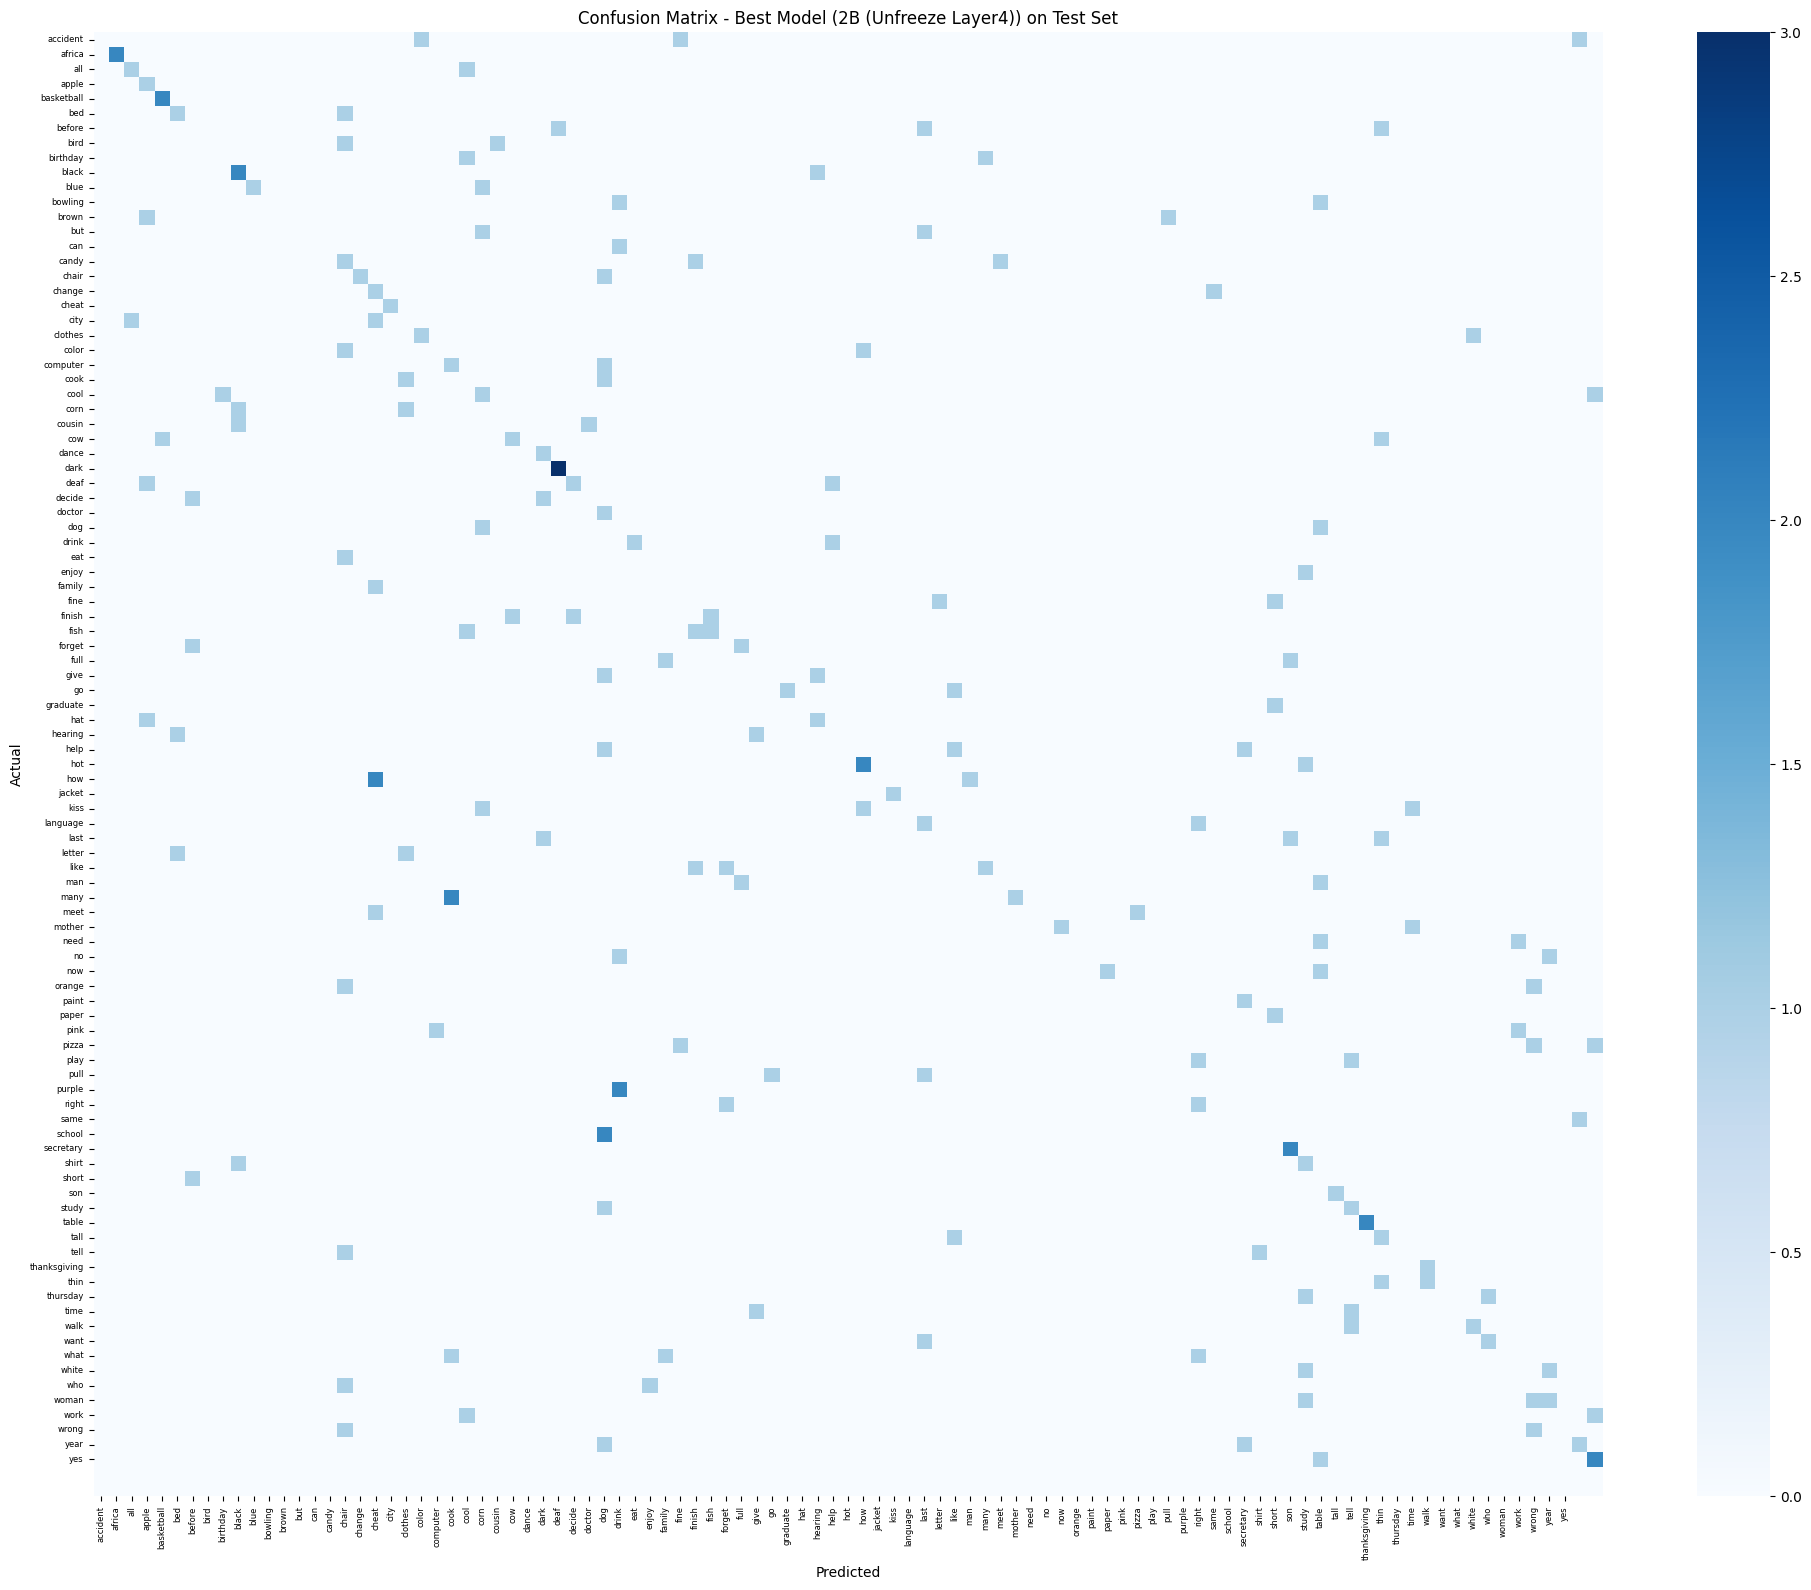

In [ ]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_config[0]}) on Test Set')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/confusion_matrix_phase2.png', dpi=150)
plt.show()

## 13. Training Curves

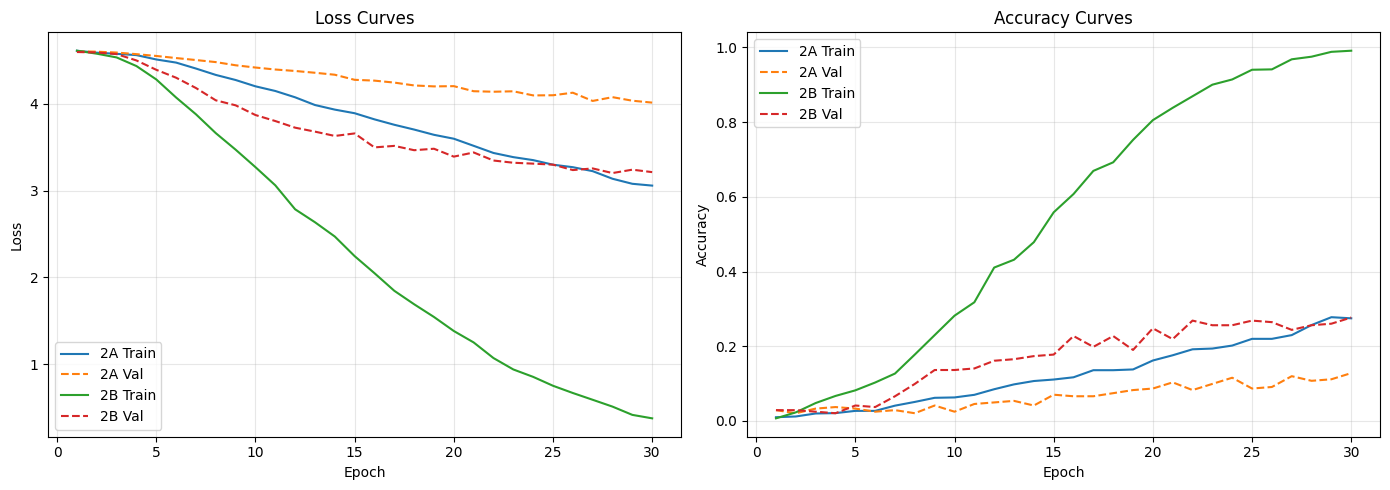

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, history in [('2A', history_2a), ('2B', history_2b)]:
    if history is None:
        continue
    epochs_range = range(1, len(history['train_loss']) + 1)
    axes[0].plot(epochs_range, history['train_loss'], label=f'{name} Train')
    axes[0].plot(epochs_range, history['val_loss'], '--', label=f'{name} Val')
    axes[1].plot(epochs_range, history['train_acc'], label=f'{name} Train')
    axes[1].plot(epochs_range, history['val_acc'], '--', label=f'{name} Val')

axes[0].set_title('Loss Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Accuracy Curves')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/training_curves_phase2.png', dpi=150)
plt.show()

## 14. Results Summary

In [17]:
results_df = pd.DataFrame(results).T
results_df.to_csv(f'{PROJECT_DIR}/phase2_results.csv')

print("\n" + "="*70)
print("PHASE 2 ABLATION RESULTS")
print("="*70)
print(f"{'Configuration':<25} {'Val Accuracy':>12} {'Val Macro-F1':>12}")
print("-"*50)
for config, metrics in results.items():
    print(f"{config:<25} {metrics['accuracy']:>12.4f} {metrics['macro_f1']:>12.4f}")
print("="*70)
print(f"\nBest model test accuracy: {test_acc:.4f}")
print(f"Best model test macro-F1: {test_f1:.4f}")
print("\nResults saved to phase2_results.csv")


PHASE 2 ABLATION RESULTS
Configuration             Val Accuracy Val Macro-F1
--------------------------------------------------
2A (Freeze CNN)                 0.1281       0.1043
2B (Unfreeze Layer4)            0.2769       0.2342

Best model test accuracy: 0.0750
Best model test macro-F1: 0.0608

Results saved to phase2_results.csv
